# __Image classification using random forest__

Classification of microscopic images <br>
Two classes: <br>
A - field with no colony <br>
B - field with colony

For model training the folder structure should be: <br>
    data folder: <br>
- A subfolder - jpg images with no colonies (negative class) <br>
- B subfolder - jpg images with colonies (positive class) <br>

In [1]:
import os
from PIL import Image
# data wrangling
import numpy as np
import pandas as pd
# ML packages
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, recall_score, confusion_matrix
import joblib
# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Global variables
TARGET_SIZE = (224, 224) # must equal with the target size of unstacking workflow!
THRESHOLD = 0.4 # threshold for binary classification

In [4]:
def prepare_data(base_folder, target_size=TARGET_SIZE, normalize=True):
    """
    Prepare image data and labels for logistic regression from folders of JPG images.
    
    Args:
    base_folder (str): Path to the base folder containing 'A' and 'B' subfolders.
    target_size (tuple): Desired size of the output images (height, width).
    normalize (bool): If True, normalize pixel values to [0, 1].
    
    Returns:
    tuple: (X, y) where X is a numpy array of flattened image data and y is a numpy array of labels.
    """
    
    # Check if base folder exists
    if not os.path.exists(base_folder):
        raise FileNotFoundError(f"The base folder {base_folder} does not exist.")
    
    # Check if 'A' and 'B' subfolders exist
    folder_a = os.path.join(base_folder, 'A')
    folder_b = os.path.join(base_folder, 'B')
    if not os.path.exists(folder_a) or not os.path.exists(folder_b):
        raise FileNotFoundError(f"Both 'A' and 'B' subfolders must exist in {base_folder}")
    
    X = []
    y = []
    
    # Process images in folder A (class 0)
    for filename in os.listdir(folder_a):
        if filename.lower().endswith(('.jpeg', '.jpg')):
            X.append(process_image(os.path.join(folder_a, filename), target_size, normalize))
            y.append(0)
    
    # Process images in folder B (class 1)
    for filename in os.listdir(folder_b):
        if filename.lower().endswith(('.jpeg', '.jpg')):
            X.append(process_image(os.path.join(folder_b, filename), target_size, normalize))
            y.append(1)
    
    return np.array(X), np.array(y)

def process_image(file_path, target_size, normalize):
    """
    Process a single image file.
    
    Args:
    file_path (str): Path to the image file.
    target_size (tuple): Desired size of the output image (height, width).
    normalize (bool): If True, normalize pixel values to [0, 1].
    
    Returns:
    numpy.ndarray: Flattened image array.
    """
    with Image.open(file_path) as img:
        # Convert to RGB if it's not already
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Resize the image
        img = img.resize(target_size)
        
        # Convert to numpy array
        img_array = np.array(img)
        
        # Normalize if required
        if normalize:
            img_array = img_array.astype(np.float32) / 255.0
        
        # Flatten the image
        return img_array.reshape(-1)


__Random Forest__

_train_random_forest_ function performs the Random forest. Following GridSearchCV it exports the best model candidate. If the best model exists worth checking a prediction with that one. 

In [5]:
def train_random_forest(X, y, test_size=0.2, random_state=42, threshold=THRESHOLD):
    """
    Train a Random Forest classifier with hyperparameter tuning and evaluation,
    using a custom classification threshold.
    
    Args:
    X (np.array): Feature matrix
    y (np.array): Target vector
    test_size (float): Proportion of the dataset to include in the test split
    random_state (int): Random state for reproducibility
    threshold (float): Classification threshold for positive class (default: 0.4)
    
    Returns:
    tuple: (best_model, accuracy, auroc)
    """
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                       random_state=random_state, 
                                                       stratify=y)
    
    # Create a pipeline with StandardScaler and RandomForestClassifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(random_state=random_state))
    ])
    
    # Define parameter grid for GridSearchCV
    param_grid = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__max_features': ['sqrt', 'log2'],
        'classifier__class_weight': ['balanced', 'balanced_subsample', None]
    }
    
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring=['accuracy', 'recall_macro', 'roc_auc'],
        refit='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit the grid search
    print("Starting GridSearchCV...")
    grid_search.fit(X_train, y_train)
    
    # Get best model
    best_model = grid_search.best_estimator_
    print(f"\nBest parameters: {grid_search.best_params_}")
    
    # Make predictions with custom threshold
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auroc = roc_auc_score(y_test, y_pred_proba)
    sens = recall_score(y_test, y_pred, average=None)
    prec = precision_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average=None)
    
    # Get feature importances
    feature_imp = pd.DataFrame(
        best_model.named_steps['classifier'].feature_importances_,
        columns=['importance']
    )
    feature_imp = feature_imp.sort_values('importance', ascending=False)
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_imp)), feature_imp['importance'])
    plt.title('Feature Importances in Random Forest Model')
    plt.xlabel('Feature Index')
    plt.ylabel('Importance')
    plt.savefig("../results/feature_importances.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    
    # Plot ROC curve with threshold point
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUROC = {auroc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
    
    # Find the point on ROC curve closest to our chosen threshold
    idx = np.argmin(np.abs(thresholds - threshold))
    plt.plot(fpr[idx], tpr[idx], 'go', label=f'Threshold = {threshold}')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve with Custom Threshold')
    plt.legend(loc="lower right")
    plt.savefig("../results/plot_rf_roc_threshold.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (threshold={threshold})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig("../results/confusion_matrix_threshold.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    
    # Save metrics
    metrics = pd.DataFrame({
        'threshold': [str(threshold)],
        'accuracy': [str(round(accuracy, 2))],
        'AUROC': [str(round(auroc, 2))],
        'recall_for_class0': [str(round(sens[0], 2))],
        'recall_for_class1': [str(round(sens[1], 2))],
        'precision_for_class0': [str(round(prec[0], 2))],
        'precision_for_class1': [str(round(prec[1], 2))],
        'f1_for_class0': [str(round(f1[0], 2))],
        'f1_for_class1': [str(round(f1[1], 2))],
        'best_params': [str(grid_search.best_params_)]
    })
    metrics.to_csv("../results/rf_training_metrics_threshold.tsv", sep='\t')
    
    # Print detailed results
    print(f"\nModel Performance Metrics (threshold={threshold}):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUROC: {auroc:.4f}")
    print(f"Recall for class 0: {sens[0]:.4f}")
    print(f"Recall for class 1: {sens[1]:.4f}")
    print(f"Precision for class 0: {prec[0]:.4f}")
    print(f"Precision for class 1: {prec[1]:.4f}")
    print(f"F1-score for class 0: {f1[0]:.4f}")
    print(f"F1-score for class 1: {f1[1]:.4f}")
    
    # Save the model
    print("\nSaving model...")
    joblib.dump(best_model, "best_random_forest_model.joblib")
    
    return best_model, accuracy, auroc

In [6]:
def predict_random_forest(X, model_path, threshold=THRESHOLD):
    """
    Make predictions using a saved random forest model with a custom classification threshold.
    
    Args:
    X (np.array): Feature matrix to predict on (output from prepare_data function)
    model_path (str): Path to the saved model file
    threshold (float): Classification threshold for positive class (default: 0.4)
    
    Returns:
    tuple: (predictions, probabilities, prediction_metrics)
    """
    
    # Load the saved model
    pipeline = joblib.load(model_path)
    
    # Get probabilities
    probabilities = pipeline.predict_proba(X)[:, 1]
    
    # Apply custom threshold
    predictions = (probabilities >= threshold).astype(int)
    
    # Create a DataFrame with both predictions and probabilities
    prediction_metrics = pd.DataFrame({
        'predicted_class': predictions,
        'probability_class_1': probabilities,
        'threshold_used': threshold
    })
    
    # Add a column indicating if the prediction was made with high confidence
    confidence_margin = 0.15  # configurable margin around the threshold
    prediction_metrics['high_confidence'] = (
        (probabilities < (threshold - confidence_margin)) | 
        (probabilities > (threshold + confidence_margin))
    )
    
    return predictions, probabilities, prediction_metrics

__Training Random Forest on the jpg files__

Starting GridSearchCV...
Fitting 5 folds for each of 648 candidates, totalling 3240 fits

Best parameters: {'classifier__class_weight': 'balanced_subsample', 'classifier__max_depth': None, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 300}


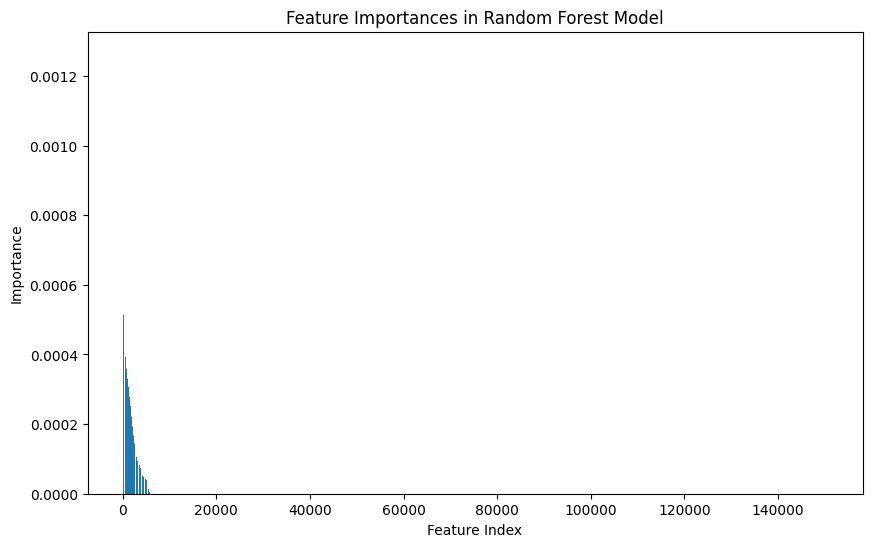

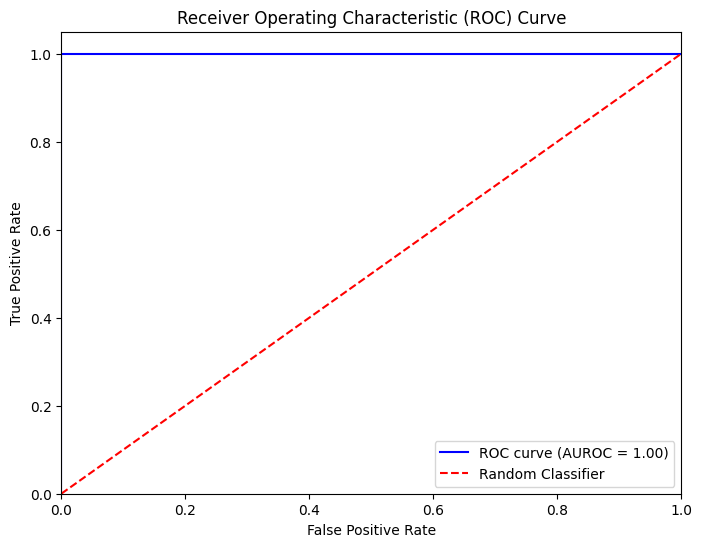

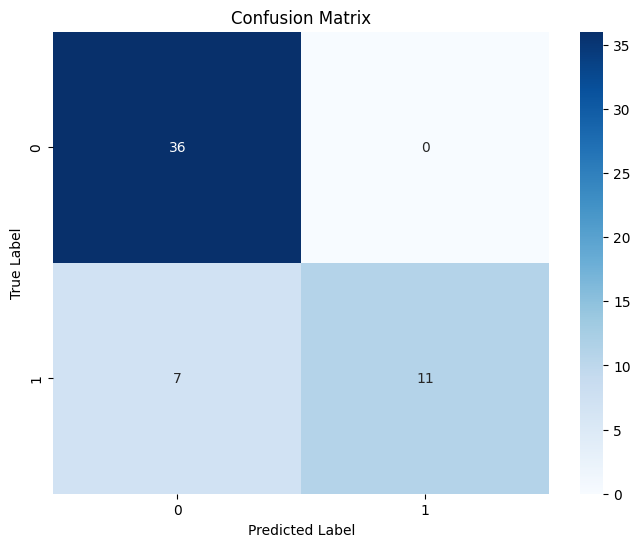


Model Performance Metrics:
Accuracy: 0.8704
AUROC: 1.0000
Recall for class 0: 1.0000
Recall for class 1: 0.6111

Saving model...


(Pipeline(steps=[('scaler', StandardScaler()),
                 ('classifier',
                  RandomForestClassifier(class_weight='balanced_subsample',
                                         max_features='log2',
                                         min_samples_split=5, n_estimators=300,
                                         random_state=42))]),
 0.8703703703703703,
 1.0)

In [4]:
X, y = prepare_data(base_folder="../data/train/jpg/")
train_random_forest(X = X, y = y)

__Prediction on new jpg files__

These confocal images returned from the _unstack.ipynb_ pipeline. 

In [10]:
tests = []
test_folder = "../data/test/jpg/"
filenames = []
for tif in os.listdir(test_folder):
    if tif.lower().endswith(('.jpg', '.jpeg')):
        test = process_image(test_folder + tif, target_size=TARGET_SIZE, normalize=True)
        filenames.append(tif)
        tests.append(test)
        
preds = predict_random_forest(X = tests, model_path="best_random_forest_model.joblib")
results = pd.DataFrame({'filename': filenames, 'pred_class': preds[0], 'prob': preds[1]})
results.to_csv("../results/random_forest.tsv")
print(results)

                                     filename  pred_class      prob
0                 B04_t0_PGL_s00_channel3.jpg           0  0.085582
1                 B04_t0_PGL_s15_channel3.jpg           0  0.058672
2                 B04_t0_PGL_s16_channel3.jpg           0  0.043624
3                 B04_t0_PGL_s27_channel3.jpg           0  0.027284
4                 B04_t0_PGL_s35_channel3.jpg           0  0.018499
5                C02_t0_PXGL_s05_channel3.jpg           0  0.093463
6                C02_t0_PXGL_s17_channel3.jpg           0  0.094279
7                C02_t0_PXGL_s26_channel3.jpg           0  0.082762
8                C02_t0_PXGL_s32_channel3.jpg           0  0.097567
9                C02_t0_PXGL_s44_channel3.jpg           1  0.558880
10               C04_t0_PXGL_s05_channel3.jpg           1  0.448249
11               C04_t0_PXGL_s10_channel3.jpg           0  0.149292
12               C04_t0_PXGL_s21_channel3.jpg           0  0.158945
13               C04_t0_PXGL_s40_channel3.jpg   